In [ ]:
# ==========================================================================
# CELL 1: INSTALL LIBRARIES AND MOUNT GOOGLE DRIVE
# ==========================================================================
"""
Install all required libraries for:
- YOLOv8 training and inference on ADD 256 dataset
- Data handling and conversion (circle to bbox)
- Visualization and analysis
- GPU acceleration
"""

# Install ultralytics (YOLOv8)
!pip install -q ultralytics

# Install additional required libraries
!pip install -q opencv-python pillow numpy pandas matplotlib seaborn
!pip install -q torch torchvision torchaudio
!pip install -q tqdm requests scikit-learn
!pip install -q requests-download  # For downloading ADD 256

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

print("✓ All libraries installed successfully!")
print("✓ Google Drive mounted successfully!")

# Verify GPU availability
import torch
print(f"\n✓ GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.6 MB/s eta 0:00:00
✓ All libraries installed successfully!
✓ Google Drive mounted successfully!

✓ GPU Available: True
  GPU Name: Tesla T4
  GPU Memory: 15.83 GB


In [ ]:
# ==========================================================================
# CELL 2: CREATE DIRECTORY STRUCTURE FOR ADD 256 DATASET
# ==========================================================================
"""
Create organized folder structure in Google Drive to store:
1. ADD 256 raw dataset (downloaded)
2. Processed dataset in YOLO format
3. Fine-tuned models
4. Fine-tuning results and metrics
5. Visualizations (bounding boxes, predictions)
"""

import os
from pathlib import Path

# Define base directories
base_drive = '/content/drive/My Drive'

# Create main project directory for ADD 256
project_dir = Path(base_drive) / 'YOLO_ADD256_Finetuning'
project_dir.mkdir(exist_ok=True)

# Create subdirectories
dataset_raw_dir = project_dir / 'ADD256_Raw'
dataset_processed_dir = project_dir / 'ADD256_YOLO_Format'
models_dir = project_dir / 'Models'
results_dir = project_dir / 'Results/YOLOv8'
runs_dir = project_dir / 'Training_Runs'
visualizations_dir = project_dir / 'Visualizations'

# Create all directories
for directory in [dataset_raw_dir, dataset_processed_dir, models_dir,
                  results_dir, runs_dir, visualizations_dir]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created: {directory}")

# Display directory structure
print("\n" + "="*80)
print("DIRECTORY STRUCTURE CREATED:")
print("="*80)
print(f"""
{project_dir.name}/
├── ADD256_Raw/ (Raw dataset - will be downloaded here)
├── ADD256_YOLO_Format/ (Processed dataset in YOLO format)
│   ├── images/
│   │   ├── train/
│   │   └── val/
│   └── labels/
│       ├── train/
│       └── val/
├── Models/ (Fine-tuned model weights)
├── Results/ (Metrics and analysis)
├── Training_Runs/ (Training logs)
└── Visualizations/ (Dataset & Prediction visualizations)
""")

print(f"Project root: {project_dir}")


✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_Raw
✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format
✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/Models
✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/Results/YOLOv8
✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/Training_Runs
✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/Visualizations

DIRECTORY STRUCTURE CREATED:

YOLO_ADD256_Finetuning/
├── ADD256_Raw/ (Raw dataset - will be downloaded here)
├── ADD256_YOLO_Format/ (Processed dataset in YOLO format)
│   ├── images/
│   │   ├── train/
│   │   └── val/
│   └── labels/
│       ├── train/
│       └── val/
├── Models/ (Fine-tuned model weights)
├── Results/ (Metrics and analysis)
├── Training_Runs/ (Training logs)
└── Visualizations/ (Dataset & Prediction visualizations)

Project root: /content/drive/My Drive/YOLO_ADD256_Finetuning


In [ ]:
# ==========================================================================
# CELL 3: DOWNLOAD ADD 256 DATASET (CORRECTED)
# ==========================================================================

import json
import zipfile
import requests
from pathlib import Path
from tqdm import tqdm

print("="*80)
print("DOWNLOADING ADD 256 DATASET")
print("="*80)

# Your project path; change to match your directory structure
dataset_raw_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_Raw')

# Direct GitHub URL for ADD 256 repository and ZIP
github_url = 'https://github.com/thsant/add256'
dataset_url = 'https://github.com/thsant/add256/archive/refs/heads/main.zip'

print(f"\n1. Downloading ADD 256 dataset from GitHub...")
print(f"   URL: {github_url}")
print(f"   This may take 5-10 minutes depending on connection speed...\n")

try:
    # Download the repository as zip
    zip_path = dataset_raw_dir / 'add256-main.zip'
    response = requests.get(dataset_url, stream=True)

    total_size = int(response.headers.get('content-length', 0))
    with open(zip_path, 'wb') as f:
        with tqdm(total=total_size, unit='B', unit_scale=True,
                 desc='Downloading') as pbar:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

    print("✓ Download completed!")

    # Extract zip file
    print(f"\n2. Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_raw_dir)

    print("✓ Extraction completed!")

    # Verify downloaded files
    print(f"\n3. Verifying downloaded files...")
    extracted_dir = dataset_raw_dir / 'add256-main'

    # Find images and annotations
    images_found = list(extracted_dir.rglob('*.jpg'))
    json_files = list(extracted_dir.rglob('*.json'))

    print(f"   ✓ Images found: {len(images_found)}")
    print(f"   ✓ JSON files found: {len(json_files)}")

    if json_files:
        # Pick the main annotation file ("annotations.json" or first file)
        # Option: Find file named exactly "annotations.json"
        annotations_file = None
        for jf in json_files:
            if jf.name.lower() == 'annotations.json':
                annotations_file = jf
                break
        if annotations_file is None:  # Fallback
            annotations_file = json_files[0]

        print(f"   ✓ Annotations file: {annotations_file.name}")

        # Load and display sample annotation
        with open(annotations_file, 'r') as f:
            annotations = json.load(f)

        sample_imgs = list(annotations.keys())
        sample_img = sample_imgs[0]   # First image name
        print(f"\n4. Sample annotation structure:")
        print(f"   Image: {sample_img}")
        print(f"   Annotations: {annotations[sample_img]}")
        print(f"   Total annotated images: {len(annotations)}")

    print("\n✓ Dataset download and extraction completed!")

except Exception as e:
    print(f"✗ Error downloading dataset: {e}")
    print("\nAlternative: Download manually from:")
    print("  - GitHub: https://github.com/thsant/add256")
    print("  - Extract and place in ADD256_Raw directory")

DOWNLOADING ADD 256 DATASET

1. Downloading ADD 256 dataset from GitHub...
   URL: https://github.com/thsant/add256
   This may take 5-10 minutes depending on connection speed...



Downloading: 52.6MB [00:01, 37.8MB/s]


✓ Download completed!

2. Extracting dataset...
✓ Extraction completed!

3. Verifying downloaded files...
   ✓ Images found: 2400
   ✓ JSON files found: 3
   ✓ Annotations file: all.json

4. Sample annotation structure:
   Image: gebler-000-04.jpg
   Annotations: []
   Total annotated images: 1139

✓ Dataset download and extraction completed!


In [ ]:
# ==========================================================================
# CELL 4: CONVERT ADD 256 CIRCULAR ANNOTATIONS TO YOLO FORMAT (CORRECTED)
# ==========================================================================

import json
import numpy as np
from pathlib import Path
import shutil
from PIL import Image

print("="*80)
print("CONVERTING ADD 256 CIRCULAR ANNOTATIONS TO YOLO FORMAT")
print("="*80)

# Paths
dataset_raw_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_Raw')
dataset_processed_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format')

# Find extracted directory and annotation file
extracted_dir = dataset_raw_dir / 'add256-main'
if not extracted_dir.exists():
    # Try alternative paths
    candidates = list(dataset_raw_dir.glob('add256*'))
    if len(candidates) > 0:
        extracted_dir = candidates[0]
    else:
        raise Exception("Cannot find extracted ADD 256 directory!")

print(f"1. Found extracted directory: {extracted_dir}")

# Find image directory
images_dirs = list(extracted_dir.rglob('images')) + list(extracted_dir.rglob('imgs'))
if not images_dirs:
    print("   ⚠ Image directory not found in standard locations")
    print("   Searching for .jpg files...")
    jpg_files = list(extracted_dir.rglob('*.jpg'))
    if jpg_files:
        images_dir = jpg_files[0].parent
        print(f"   Found images in: {images_dir}")
    else:
        raise Exception("No JPG images found!")
else:
    images_dir = images_dirs[0]  # Use first match

# Find annotation file
json_files = list(extracted_dir.rglob('*.json'))
if not json_files:
    raise Exception("No JSON annotations file found!")

# Prefer annotations.json; fallback to first file
annotations_file = None
for jf in json_files:
    if jf.name.lower() == 'annotations.json':
        annotations_file = jf
        break
if annotations_file is None:
    annotations_file = json_files[0]

print(f"   Annotations file: {annotations_file.name}")

# Load annotations
print(f"\n2. Loading annotations...")
with open(annotations_file, 'r') as f:
    annotations_data = json.load(f)

print(f"   ✓ Loaded annotations for {len(annotations_data)} images")
print(f"   ✓ Total apple instances: {sum(len(v) for v in annotations_data.values())}")

# Create YOLO format directories
images_yolo_dir = dataset_processed_dir / 'images'
labels_yolo_dir = dataset_processed_dir / 'labels'
images_yolo_dir.mkdir(parents=True, exist_ok=True)
labels_yolo_dir.mkdir(parents=True, exist_ok=True)

# Function to convert circular annotation to YOLO bbox
def circle_to_yolo_bbox(cx, cy, radius, img_width=256, img_height=256):
    x_min = max(0, cx - radius)
    y_min = max(0, cy - radius)
    x_max = min(img_width, cx + radius)
    y_max = min(img_height, cy + radius)
    center_x = (x_min + x_max) / 2.0 / img_width
    center_y = (y_min + y_max) / 2.0 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return center_x, center_y, width, height

# Convert annotations
print(f"\n3. Converting annotations and copying images...")
conversion_count = 0
error_count = 0

for img_filename, annotations_list in annotations_data.items():
    try:
        # Find source image
        source_img_path = images_dir / img_filename
        if not source_img_path.exists():
            print(f"   ✗ Image not found: {img_filename}")
            error_count += 1
            continue

        # Copy image to YOLO format directory
        dest_img_path = images_yolo_dir / img_filename
        shutil.copy2(source_img_path, dest_img_path)

        # Get image dimensions (should be 256x256, but verify)
        with Image.open(source_img_path) as img:
            img_width, img_height = img.size

        # Create YOLO label file
        yolo_annotations = []
        for ann in annotations_list:
            cx = ann['cx']
            cy = ann['cy']
            radius = ann['r']
            center_x, center_y, width, height = circle_to_yolo_bbox(
                cx, cy, radius, img_width, img_height)
            yolo_annotations.append(f"0 {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}")

        # Write YOLO label file
        label_filename = Path(img_filename).stem + '.txt'
        label_path = labels_yolo_dir / label_filename
        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

        conversion_count += 1
        if conversion_count % 100 == 0:
            print(f"   ✓ Converted {conversion_count} images...")

    except Exception as e:
        print(f"   ✗ Error processing {img_filename}: {e}")
        error_count += 1

print(f"\n4. Conversion Summary:")
print(f"   ✓ Successfully converted: {conversion_count} images")
print(f"   ✗ Errors: {error_count}")

# Verify conversion
print(f"\n5. Verifying conversion...")
image_files = sorted(list(images_yolo_dir.glob('*.jpg')))
label_files = sorted(list(labels_yolo_dir.glob('*.txt')))
print(f"   ✓ Images: {len(image_files)}")
print(f"   ✓ Labels: {len(label_files)}")
if len(image_files) != len(label_files):
    print(f"   ⚠ Warning: Mismatch between images and labels!")
else:
    print(f"   ✓ Perfect match!")

# Display sample annotation
if label_files:
    sample_label = label_files[0]
    print(f"\n6. Sample YOLO annotation (from {sample_label.name}):")
    with open(sample_label, 'r') as f:
        content = f.read()
        lines = content.strip().split('\n')[:3]
        for line in lines:
            print(f"   {line}")
        if len(content.strip().split('\n')) > 3:
            print(f"   ... ({len(content.strip().split(chr(10)))} total apples)")
        if not content:
            print(f"   (empty - no apples in this image)")

print("\n" + "="*80)
print("✓ CONVERSION COMPLETED!")
print("="*80)

CONVERTING ADD 256 CIRCULAR ANNOTATIONS TO YOLO FORMAT
1. Found extracted directory: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_Raw/add256-main
   Annotations file: all.json

2. Loading annotations...
   ✓ Loaded annotations for 1139 images
   ✓ Total apple instances: 2471

3. Converting annotations and copying images...
   ✓ Converted 100 images...
   ✓ Converted 200 images...
   ✓ Converted 300 images...
   ✓ Converted 400 images...
   ✓ Converted 500 images...
   ✓ Converted 600 images...
   ✓ Converted 700 images...
   ✓ Converted 800 images...
   ✓ Converted 900 images...
   ✓ Converted 1000 images...
   ✓ Converted 1100 images...

4. Conversion Summary:
   ✓ Successfully converted: 1139 images
   ✗ Errors: 0

5. Verifying conversion...
   ✓ Images: 1139
   ✓ Labels: 1139
   ✓ Perfect match!

6. Sample YOLO annotation (from gebler-000-04.txt):
   
   (empty - no apples in this image)

✓ CONVERSION COMPLETED!


In [ ]:
# ==========================================================================
# CELL 5: CREATE TRAIN/VAL SPLIT AND DATASET.YAML
# ==========================================================================
"""
Split ADD 256 dataset into training (80%) and validation (20%) sets.
Create dataset.yaml configuration file for YOLOv8 training.

For such a small dataset, we use 80/20 split to maximize training data.
"""

import os
import shutil
from pathlib import Path
import random
import yaml

print("="*80)
print("CREATING TRAIN/VAL SPLIT FOR ADD 256")
print("="*80)

# Paths
dataset_processed_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format')
images_dir = dataset_processed_dir / 'images'
labels_dir = dataset_processed_dir / 'labels'

# Create YOLOv8 directory structure
train_images_dir = images_dir / 'train'
train_labels_dir = labels_dir / 'train'
val_images_dir = images_dir / 'val'
val_labels_dir = labels_dir / 'val'

for directory in [train_images_dir, train_labels_dir, val_images_dir, val_labels_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# Get all images
all_images = sorted(list(images_dir.glob('*.jpg')))
print(f"\n1. Total images: {len(all_images)}")

if len(all_images) == 0:
    raise Exception("No images found! Check CELL 4 conversion.")

# Split into train (80%) and val (20%)
random.seed(42)  # For reproducibility
random.shuffle(all_images)
split_idx = int(0.8 * len(all_images))
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

print(f"   Training images: {len(train_images)} (80%)")
print(f"   Validation images: {len(val_images)} (20%)")

# Copy training images and labels
print(f"\n2. Copying training data...")
train_copied = 0
train_errors = 0

for img_path in train_images:
    try:
        shutil.copy2(img_path, train_images_dir / img_path.name)

        label_path = labels_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            shutil.copy2(label_path, train_labels_dir / label_path.name)
            train_copied += 1
    except Exception as e:
        print(f"   ✗ Error: {e}")
        train_errors += 1

print(f"   ✓ Copied {train_copied} training pairs")

# Copy validation images and labels
print(f"\n3. Copying validation data...")
val_copied = 0
val_errors = 0

for img_path in val_images:
    try:
        shutil.copy2(img_path, val_images_dir / img_path.name)

        label_path = labels_dir / f"{img_path.stem}.txt"
        if label_path.exists():
            shutil.copy2(label_path, val_labels_dir / label_path.name)
            val_copied += 1
    except Exception as e:
        print(f"   ✗ Error: {e}")
        val_errors += 1

print(f"   ✓ Copied {val_copied} validation pairs")

# Create dataset.yaml
print(f"\n4. Creating dataset.yaml...")

dataset_yaml = {
    'path': str(dataset_processed_dir),
    'train': 'images/train',
    'val': 'images/val',
    'nc': 1,  # Only 1 class: apples
    'names': ['apple']  # Class name
}

yaml_path = dataset_processed_dir / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(dataset_yaml, f, default_flow_style=False, sort_keys=False)

print(f"   ✓ Created: {yaml_path}")

# Display dataset.yaml
print(f"\n5. dataset.yaml content:")
print("   " + "="*70)
with open(yaml_path, 'r') as f:
    for line in f:
        print(f"   {line.rstrip()}")
print("   " + "="*70)

# Verify split
print(f"\n6. Final verification:")
train_img_count = len(list(train_images_dir.glob('*.jpg')))
train_lbl_count = len(list(train_labels_dir.glob('*.txt')))
val_img_count = len(list(val_images_dir.glob('*.jpg')))
val_lbl_count = len(list(val_labels_dir.glob('*.txt')))

print(f"""
ADD256_YOLO_Format/
├── images/
│   ├── train/ ({train_img_count} images)
│   └── val/ ({val_img_count} images)
├── labels/
│   ├── train/ ({train_lbl_count} labels)
│   └── val/ ({val_lbl_count} labels)
└── dataset.yaml
""")

if train_img_count == train_lbl_count and val_img_count == val_lbl_count:
    print("✓ Perfect match! All images have corresponding labels")
else:
    print("⚠ Warning: Mismatch between images and labels!")

print("\n" + "="*80)
print("✓ DATASET PREPARATION COMPLETED!")
print("="*80)


CREATING TRAIN/VAL SPLIT FOR ADD 256

1. Total images: 1139
   Training images: 911 (80%)
   Validation images: 228 (20%)

2. Copying training data...
   ✓ Copied 911 training pairs

3. Copying validation data...
   ✓ Copied 228 validation pairs

4. Creating dataset.yaml...
   ✓ Created: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format/dataset.yaml

5. dataset.yaml content:
   path: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format
   train: images/train
   val: images/val
   nc: 1
   names:
   - apple

6. Final verification:

ADD256_YOLO_Format/
├── images/
│   ├── train/ (911 images)
│   └── val/ (228 images)
├── labels/
│   ├── train/ (911 labels)
│   └── val/ (228 labels)
└── dataset.yaml

✓ Perfect match! All images have corresponding labels

✓ DATASET PREPARATION COMPLETED!


In [ ]:
# ==========================================================================
# CELL 6: LOAD BEST NWPU VHR-10 TRAINED MODEL
# ==========================================================================
"""
Load your best trained YOLO model from NWPU VHR-10 training.
This model will be fine-tuned on the ADD 256 dataset.
"""

from ultralytics import YOLO
from pathlib import Path
import torch

print("="*80)
print("LOADING BEST NWPU VHR-10 TRAINED MODEL")
print("="*80)

# Check GPU
if torch.cuda.is_available():
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"\n✓ GPU Memory Available: {gpu_memory:.2f} GB")
else:
    print("\n⚠ GPU not available")

# Paths
nwpu_models_dir = Path('/content/drive/My Drive/YOLO_NWPU_VHR10/Models')
add256_models_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Models')

# List available models from NWPU training
print(f"\n1. Searching for trained NWPU VHR-10 models...")
if nwpu_models_dir.exists():
    model_files = list(nwpu_models_dir.glob('*.pt'))
    if model_files:
        print(f"   ✓ Found {len(model_files)} trained model(s):")
        for model_file in model_files:
            print(f"     - {model_file.name} ({model_file.stat().st_size / 1e6:.2f} MB)")
    else:
        print(f"   ⚠ No .pt files found in {nwpu_models_dir}")
else:
    print(f"   ⚠ NWPU models directory not found: {nwpu_models_dir}")

# Try to load best model
print(f"\n2. Loading model for fine-tuning...")

best_model_path = nwpu_models_dir / 'yolov8s_nwpu_vhr_10_best_balanced.pt'

if best_model_path.exists():
    print(f"   ✓ Found best model: {best_model_path.name}")
    model = YOLO(str(best_model_path))
    print(f"   ✓ Model loaded successfully!")
else:
    print(f"   ⚠ Best model not found at {best_model_path}")
    print(f"   Attempting to load alternative model...")

    # Try to find any .pt file
    model_files = list(nwpu_models_dir.glob('*.pt'))
    if model_files:
        model_to_load = model_files
        print(f"   Loading: {model_to_load.name}")
        model = YOLO(str(model_to_load))
    else:
        print(f"   ✗ No trained models found!")
        print(f"   Using pre-trained YOLOv8 Small as fallback...")
        model = YOLO('yolov8s.pt')

# Display model info
print(f"\n3. Model Information:")
print(f"   Total parameters: {sum(p.numel() for p in model.model.parameters()):,}")
print(f"   Device: {next(model.model.parameters()).device}")

print("\n✓ Model loaded successfully!")
print("\nNext: Run CELL 7 to fine-tune on ADD 256 dataset")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
LOADING BEST NWPU VHR-10 TRAINED MODEL

✓ GPU Memory Available: 15.83 GB

1. Searching for trained NWPU VHR-10 models...
   ✓ Found 5 trained model(s):
     - yolov8s_nwpu_vhr_10_best_balanced.pt (22.53 MB)
     - yolov5_nwpu_vhr_10_best_balanced.pt (18.53 MB)
     - yolov10_nwpu_vhr_10_best_balanced.pt (16.55 MB)
     - yolov9_nwpu_vhr_10_best_balanced.pt (51.61 MB)
     - yolov11_nwpu_vhr_10_best_balanced.pt (19.19 MB)

2. Loading model for fine-tuning...
   ✓ Found best model: yolov8s_nwpu_vhr_10_best_balanced.pt
   ✓ Model loaded successfully!

3. Model Information:
   Total parameters: 11,139,470
   Device: cpu

✓ Model loaded successfully!

Next: Run CELL 7 to fine-tune on A

In [ ]:
# ==========================================================================
# CELL 7: FINE-TUNE MODEL ON ADD 256 DATASET (FULL CODE WITH COMMENTS)
# ==========================================================================

"""
This script fine-tunes your pretrained YOLOv8 model on the ADD 256 dataset.

Key features:
- Automatically detects whether GPU is available and sets device accordingly.
- Applies a lower learning rate for fine-tuning.
- Uses appropriate batch size for the 256x256 images and dataset size.
- Applies strong data augmentations for better generalization.
- Saves the best and last model checkpoints to Google Drive.

This cell ensures compatibility across different hardware setups.
"""

from ultralytics import YOLO
from pathlib import Path
import shutil
import torch

print("="*80)
print("FINE-TUNING MODEL ON ADD 256 DATASET")
print("="*80)

# Define paths to your directories on Google Drive
models_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Models')
runs_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Training_Runs')
dataset_processed_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format')
yaml_path = dataset_processed_dir / 'dataset.yaml'  # YOLOv8 data config file (train/val paths, classes)

# Load your best NWPU VHR-10 pre-trained model weights
print("\n1. Loading NWPU VHR-10 trained model...")
nwpu_model_path = Path('/content/drive/My Drive/YOLO_NWPU_VHR10/Models/yolov8s_nwpu_vhr_10_best_balanced.pt')

if nwpu_model_path.exists():
    model = YOLO(str(nwpu_model_path))
    print(f"   ✓ Loaded pre-trained model: {nwpu_model_path.name}")
else:
    print(f"   ⚠ NWPU model not found, defaulting to YOLOv8s pre-trained weights")
    model = YOLO('yolov8s.pt')

# Dynamically select device based on hardware availability
if torch.cuda.is_available():
    device_val = 0  # GPU device ID 0
    print("✓ GPU detected: Training on GPU")
else:
    device_val = 'cpu'  # CPU training
    print("✓ No GPU detected: Training on CPU")

# Display summary before training
print(f"\n2. Preparing to train on ADD 256 dataset:")
print(f"   Dataset config: {yaml_path}")
print(f"   Training images: 912 (80% of 1,139 total)")
print(f"   Validation images: 227 (20% of 1,139 total)")

# Start training / fine-tuning run
results = model.train(
    data=str(yaml_path),     # Dataset config YAML
    epochs=60,              # Number of epochs (adjust based on convergence)
    imgsz=256,              # Input image size (ADD 256 images are 256x256)
    batch=32,               # Batch size (higher for small images)
    patience=20,            # Early stopping patience (epochs)
    device=device_val,      # Use determined device ('cpu' or gpu id)

    # Learning rate hyperparameters
    lr0=0.0001,             # Initial learning rate (smaller for fine-tuning)
    lrf=0.001,              # Final learning rate factor (multiplier)
    momentum=0.937,         # SGD momentum
    weight_decay=0.0005,    # Weight decay for regularization
    optimizer='SGD',        # Optimizer algorithm

    # Warmup settings (shorter for fine-tuning)
    warmup_epochs=3,
    warmup_momentum=0.8,
    warmup_bias_lr=0.1,

    # Data augmentation parameters for robustness
    mosaic=1.0,
    mixup=0.2,
    copy_paste=0.1,
    degrees=10,
    translate=0.1,
    scale=0.3,
    flipud=0.5,
    fliplr=0.5,
    perspective=0.0001,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,

    # Validation and checkpointing settings
    save=True,
    save_period=10,         # Save model every 10 epochs
    val=True,
    verbose=True,
    project=str(runs_dir),
    name='YOLOv8_ADD256_Finetuning_from_NWPU',
    exist_ok=False,
)

print("\n✓ Fine-tuning completed!")

# Save the best and last model checkpoints to your models directory on Google Drive
best_model_path = Path(results.save_dir) / 'weights' / 'best.pt'
if best_model_path.exists():
    dest_path = models_dir / 'YOLOv8_ADD256_best_finetuned.pt'
    shutil.copy2(best_model_path, dest_path)
    print(f"✓ Saved best model checkpoint: {dest_path.name}")

    last_model_path = Path(results.save_dir) / 'weights' / 'last.pt'
    if last_model_path.exists():
        dest_last = models_dir / 'YOLOv8_ADD256_last_finetuned.pt'
        shutil.copy2(last_model_path, dest_last)
        print(f"✓ Saved last model checkpoint: {dest_last.name}")

print(f"\nTraining run saved at: {results.save_dir}")

FINE-TUNING MODEL ON ADD 256 DATASET

1. Loading NWPU VHR-10 trained model...
   ✓ Loaded pre-trained model: yolov8s_nwpu_vhr_10_best_balanced.pt
✓ GPU detected: Training on GPU

2. Preparing to train on ADD 256 dataset:
   Dataset config: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format/dataset.yaml
   Training images: 912 (80% of 1,139 total)
   Validation images: 227 (20% of 1,139 total)
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format/dataset.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5,

In [ ]:
# ==========================================================================
# CELL 8: EXTRACT TRAINING METRICS FROM FINE-TUNING (CORRECTED)
# ==========================================================================

import pandas as pd
from pathlib import Path

print("="*80)
print("EXTRACTING TRAINING METRICS")
print("="*80)

# Update these paths to your environment
runs_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Training_Runs')
results_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Results/YOLOv8')

# Find training runs sorted by modified time (latest first)
training_run_dirs = sorted(
    runs_dir.glob('YOLOv8_ADD256_Finetuning_*'),
    key=lambda p: p.stat().st_mtime,
    reverse=True
)

if not training_run_dirs:
    print("✗ No training runs found!")
    print("   Please run CELL 7 first")
    raise Exception("No training runs")

# Select the latest training run directory
latest_run_dir = training_run_dirs[0]
print(f"\n1. Found latest run: {latest_run_dir.name}")

# Load results.csv file created during training
results_csv = latest_run_dir / 'results.csv'
if not results_csv.exists():
    print(f"✗ results.csv not found at {results_csv}")
else:
    print(f"✓ Loading results.csv...")

    # Read CSV into pandas dataframe
    df = pd.read_csv(results_csv)
    print(f"   ✓ Loaded {len(df)} epochs of training data")

    # Clean column header (strip whitespace)
    df.columns = df.columns.str.strip()

    print(f"\n2. Columns available:")
    for col in df.columns:
        print(f"   - {col}")

    print(f"\n3. Training Summary:")
    print(f"   Total Epochs: {len(df)}")

    # Extract metrics for final and best epochs
    if len(df) > 0:
        final_epoch = df.iloc[-1]
        best_epoch = df.loc[df['metrics/mAP50(B)'].idxmax()]

        print(f"\n   Final Epoch ({int(final_epoch['epoch'])} + 1):")
        print(f"     • train_loss: {final_epoch['train/box_loss']:.6f}")
        print(f"     • val_loss: {final_epoch['val/box_loss']:.6f}")
        print(f"     • Precision: {final_epoch['metrics/precision(B)']:.4f}")
        print(f"     • Recall: {final_epoch['metrics/recall(B)']:.4f}")
        print(f"     • mAP50: {final_epoch['metrics/mAP50(B)']:.4f}")
        print(f"     • mAP50-95: {final_epoch['metrics/mAP50-95(B)']:.4f}")

        print(f"\n   Best Epoch ({int(best_epoch['epoch'])} + 1):")
        print(f"     • mAP50: {best_epoch['metrics/mAP50(B)']:.4f}")
        print(f"     • mAP50-95: {best_epoch['metrics/mAP50-95(B)']:.4f}")

    # Save all epoch metrics to CSV in Results directory
    metrics_output_path = results_dir / 'ADD256_finetuning_metrics.csv'
    df.to_csv(metrics_output_path, index=False)
    print(f"\n✓ Saved detailed metrics: {metrics_output_path}")

    # Create summary CSV with main overall metrics
    summary_data = {
        'Dataset': ['ADD 256'],
        'Model': ['YOLOv8s (Fine-tuned from NWPU VHR-10)'],
        'Total_Epochs': [len(df)],
        'Final_Train_Loss': [final_epoch['train/box_loss']],
        'Final_Val_Loss': [final_epoch['val/box_loss']],
        'Final_Precision': [final_epoch['metrics/precision(B)']],
        'Final_Recall': [final_epoch['metrics/recall(B)']],
        'Final_mAP50': [final_epoch['metrics/mAP50(B)']],
        'Final_mAP50_95': [final_epoch['metrics/mAP50-95(B)']],
        'Best_mAP50': [best_epoch['metrics/mAP50(B)']],
        'Best_mAP50_95': [best_epoch['metrics/mAP50-95(B)']],
        'Best_Epoch': [int(best_epoch['epoch']) + 1],
    }

    summary_df = pd.DataFrame(summary_data)
    summary_output_path = results_dir / 'ADD256_finetuning_summary.csv'
    summary_df.to_csv(summary_output_path, index=False)
    print(f"✓ Saved summary metrics: {summary_output_path}")

print("\n" + "="*80)
print("✓ METRICS EXTRACTION COMPLETED!")
print("="*80)

EXTRACTING TRAINING METRICS

1. Found latest run: YOLOv8_ADD256_Finetuning_from_NWPU
✓ Loading results.csv...
   ✓ Loaded 60 epochs of training data

2. Columns available:
   - epoch
   - time
   - train/box_loss
   - train/cls_loss
   - train/dfl_loss
   - metrics/precision(B)
   - metrics/recall(B)
   - metrics/mAP50(B)
   - metrics/mAP50-95(B)
   - val/box_loss
   - val/cls_loss
   - val/dfl_loss
   - lr/pg0
   - lr/pg1
   - lr/pg2

3. Training Summary:
   Total Epochs: 60

   Final Epoch (60 + 1):
     • train_loss: 1.558130
     • val_loss: 1.589960
     • Precision: 0.7997
     • Recall: 0.8155
     • mAP50: 0.8649
     • mAP50-95: 0.4429

   Best Epoch (57 + 1):
     • mAP50: 0.8722
     • mAP50-95: 0.4476

✓ Saved detailed metrics: /content/drive/My Drive/YOLO_ADD256_Finetuning/Results/YOLOv8/ADD256_finetuning_metrics.csv
✓ Saved summary metrics: /content/drive/My Drive/YOLO_ADD256_Finetuning/Results/YOLOv8/ADD256_finetuning_summary.csv

✓ METRICS EXTRACTION COMPLETED!


In [ ]:
# ==========================================================================
# CELL 9: VALIDATE FINE-TUNED MODEL ON ADD 256 VALIDATION SET
# ==========================================================================

"""
Run validation on the fine-tuned model to get final performance metrics.
"""

from ultralytics import YOLO
from pathlib import Path
import pandas as pd

print("="*80)
print("VALIDATING FINE-TUNED MODEL ON ADD 256")
print("="*80)

# Define paths to models and dataset folders
models_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Models')
dataset_processed_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format')
results_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Results/YOLOv8')
yaml_path = dataset_processed_dir / 'dataset.yaml'

# Load best fine-tuned model weights
best_model_path = models_dir / 'YOLOv8_ADD256_best_finetuned.pt'

print(f"\n1. Loading best fine-tuned model...")
if best_model_path.exists():
    model = YOLO(str(best_model_path))
    print(f"   ✓ Loaded: {best_model_path.name}")
else:
    print(f"   ⚠ Best model not found, using last model")
    last_model_path = models_dir / 'YOLOv8_ADD256_last_finetuned.pt'
    if last_model_path.exists():
        model = YOLO(str(last_model_path))
        print(f"   ✓ Loaded: {last_model_path.name}")
    else:
        print(f"   ✗ No model found!")
        raise Exception("Model not found")

# Run validation on ADD 256 validation set
num_val_images = 227  # Set this to your actual val image count

print(f"\n2. Running validation on ADD 256 validation set...")
print(f"   Validation images: {num_val_images}")

val_results = model.val(
    data=str(yaml_path),
    split='val',
    imgsz=256,
    batch=32,
    verbose=True,
    save_json=False,
)

# Extract metrics from validation results
print(f"\n3. Validation Metrics:")
print(f"   mAP@50: {val_results.box.map50:.4f}")
print(f"   mAP@50:95: {val_results.box.map:.4f}")
print(f"   Precision: {val_results.box.mp:.4f}")
print(f"   Recall: {val_results.box.mr:.4f}")

# Calculate F1 score
f1 = 2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr + 1e-9)
print(f"   F1 Score: {f1:.4f}")

# Save validation metrics to CSV file
val_metrics = {
    'Dataset': ['ADD 256'],
    'Model': ['YOLOv8s (Fine-tuned)'],
    'Split': ['Validation'],
    'Images': [num_val_images],
    'mAP@50': [val_results.box.map50],
    'mAP@50:95': [val_results.box.map],
    'Precision': [val_results.box.mp],
    'Recall': [val_results.box.mr],
    'F1_Score': [f1],
}

val_df = pd.DataFrame(val_metrics)
val_metrics_path = results_dir / 'ADD256_validation_metrics.csv'
val_df.to_csv(val_metrics_path, index=False)
print(f"\n✓ Saved validation metrics: {val_metrics_path}")

print("\n" + "="*80)
print("✓ VALIDATION COMPLETED!")
print("="*80)

VALIDATING FINE-TUNED MODEL ON ADD 256

1. Loading best fine-tuned model...
   ✓ Loaded: YOLOv8_ADD256_best_finetuned.pt

2. Running validation on ADD 256 validation set...
   Validation images: 227
Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.3 ms, read: 8.4±3.4 MB/s, size: 18.5 KB)
val: Scanning /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format/labels/val.cache... 228 images, 98 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 228/228 347.1Kit/s 0.0s
val: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format/images/val/gebler-000-09.jpg: 2 duplicate labels removed
val: /content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format/images/val/gebler-000-14.jpg: 4 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 3.2it/s 

In [ ]:
# ==========================================================================
# CELL 10: VISUALIZE ADD 256 DATASET
# Display 4 random training images with original bounding boxes
# ==========================================================================

"""
Visualize the ADD 256 dataset to understand the data characteristics:
- Image resolution (256x256)
- Apple instances (density, size variation)
- Annotation quality

Shows 4 random training images with their bounding boxes drawn.
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

print("="*80)
print("VISUALIZING ADD 256 DATASET")
print("="*80)

# Paths
dataset_processed_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format')
train_images_dir = dataset_processed_dir / 'images' / 'train'
train_labels_dir = dataset_processed_dir / 'labels' / 'train'
visualizations_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Visualizations')

print(f"\n1. Loading dataset...")
print(f"   Images directory: {train_images_dir}")
print(f"   Labels directory: {train_labels_dir}")

# Get all training images
all_images = sorted(list(train_images_dir.glob('*.jpg')))
print(f"   ✓ Found {len(all_images)} training images")

# Select 4 random images
random.seed(42)
sample_images = random.sample(all_images, min(4, len(all_images)))

print(f"\n2. Selected 4 random images:")
for img_path in sample_images:
    print(f"   - {img_path.name}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
fig.suptitle('ADD 256 Dataset - Original Images with Bounding Boxes',
             fontsize=16, fontweight='bold')
axes = axes.flatten()

print(f"\n3. Visualizing images with bounding boxes...")

for idx, img_path in enumerate(sample_images):
    # Read image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]

    # Read corresponding label
    label_path = train_labels_dir / f"{img_path.stem}.txt"

    apple_count = 0
    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()
            apple_count = len(lines)

    # Display image
    ax = axes[idx]
    ax.imshow(img_rgb)

    # Draw bounding boxes
    if label_path.exists():
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    cx_norm = float(parts[1])
                    cy_norm = float(parts[2])
                    w_norm = float(parts[3])
                    h_norm = float(parts[4])

                    # Convert normalized coordinates to pixel coordinates
                    x_min = int((cx_norm - w_norm/2) * img_width)
                    y_min = int((cy_norm - h_norm/2) * img_height)
                    box_width = int(w_norm * img_width)
                    box_height = int(h_norm * img_height)

                    # Draw rectangle
                    rect = Rectangle((x_min, y_min), box_width, box_height,
                                     linewidth=2, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)

    # Set title with image info
    ax.set_title(f'{img_path.name}\nApples: {apple_count} | Size: {img_width}x{img_height}',
                 fontsize=11, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
output_path = visualizations_dir / 'ADD256_dataset_samples.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"\n✓ Saved visualization: {output_path}")

plt.show()

print("\n" + "="*80)
print("✓ DATASET VISUALIZATION COMPLETED!")
print("="*80)
print("\nVisualization shows:")
print("  • Image resolution: 256x256 pixels (small images)")
print("  • Apple detection: Individual apples marked with lime green boxes")
print("  • Annotation quality: Circular annotations converted to bounding boxes")
print("  • Data characteristics: Variety of apple sizes and positions")

VISUALIZING MODEL PREDICTIONS VS GROUND TRUTH
✓ Loaded model: YOLOv8_ADD256_best_finetuned.pt
Selected 4 random validation images:
 - vitrine-010-02.jpg
 - gebler-012-15.jpg
 - gebler-002-04.jpg
 - vitrine-024-06.jpg


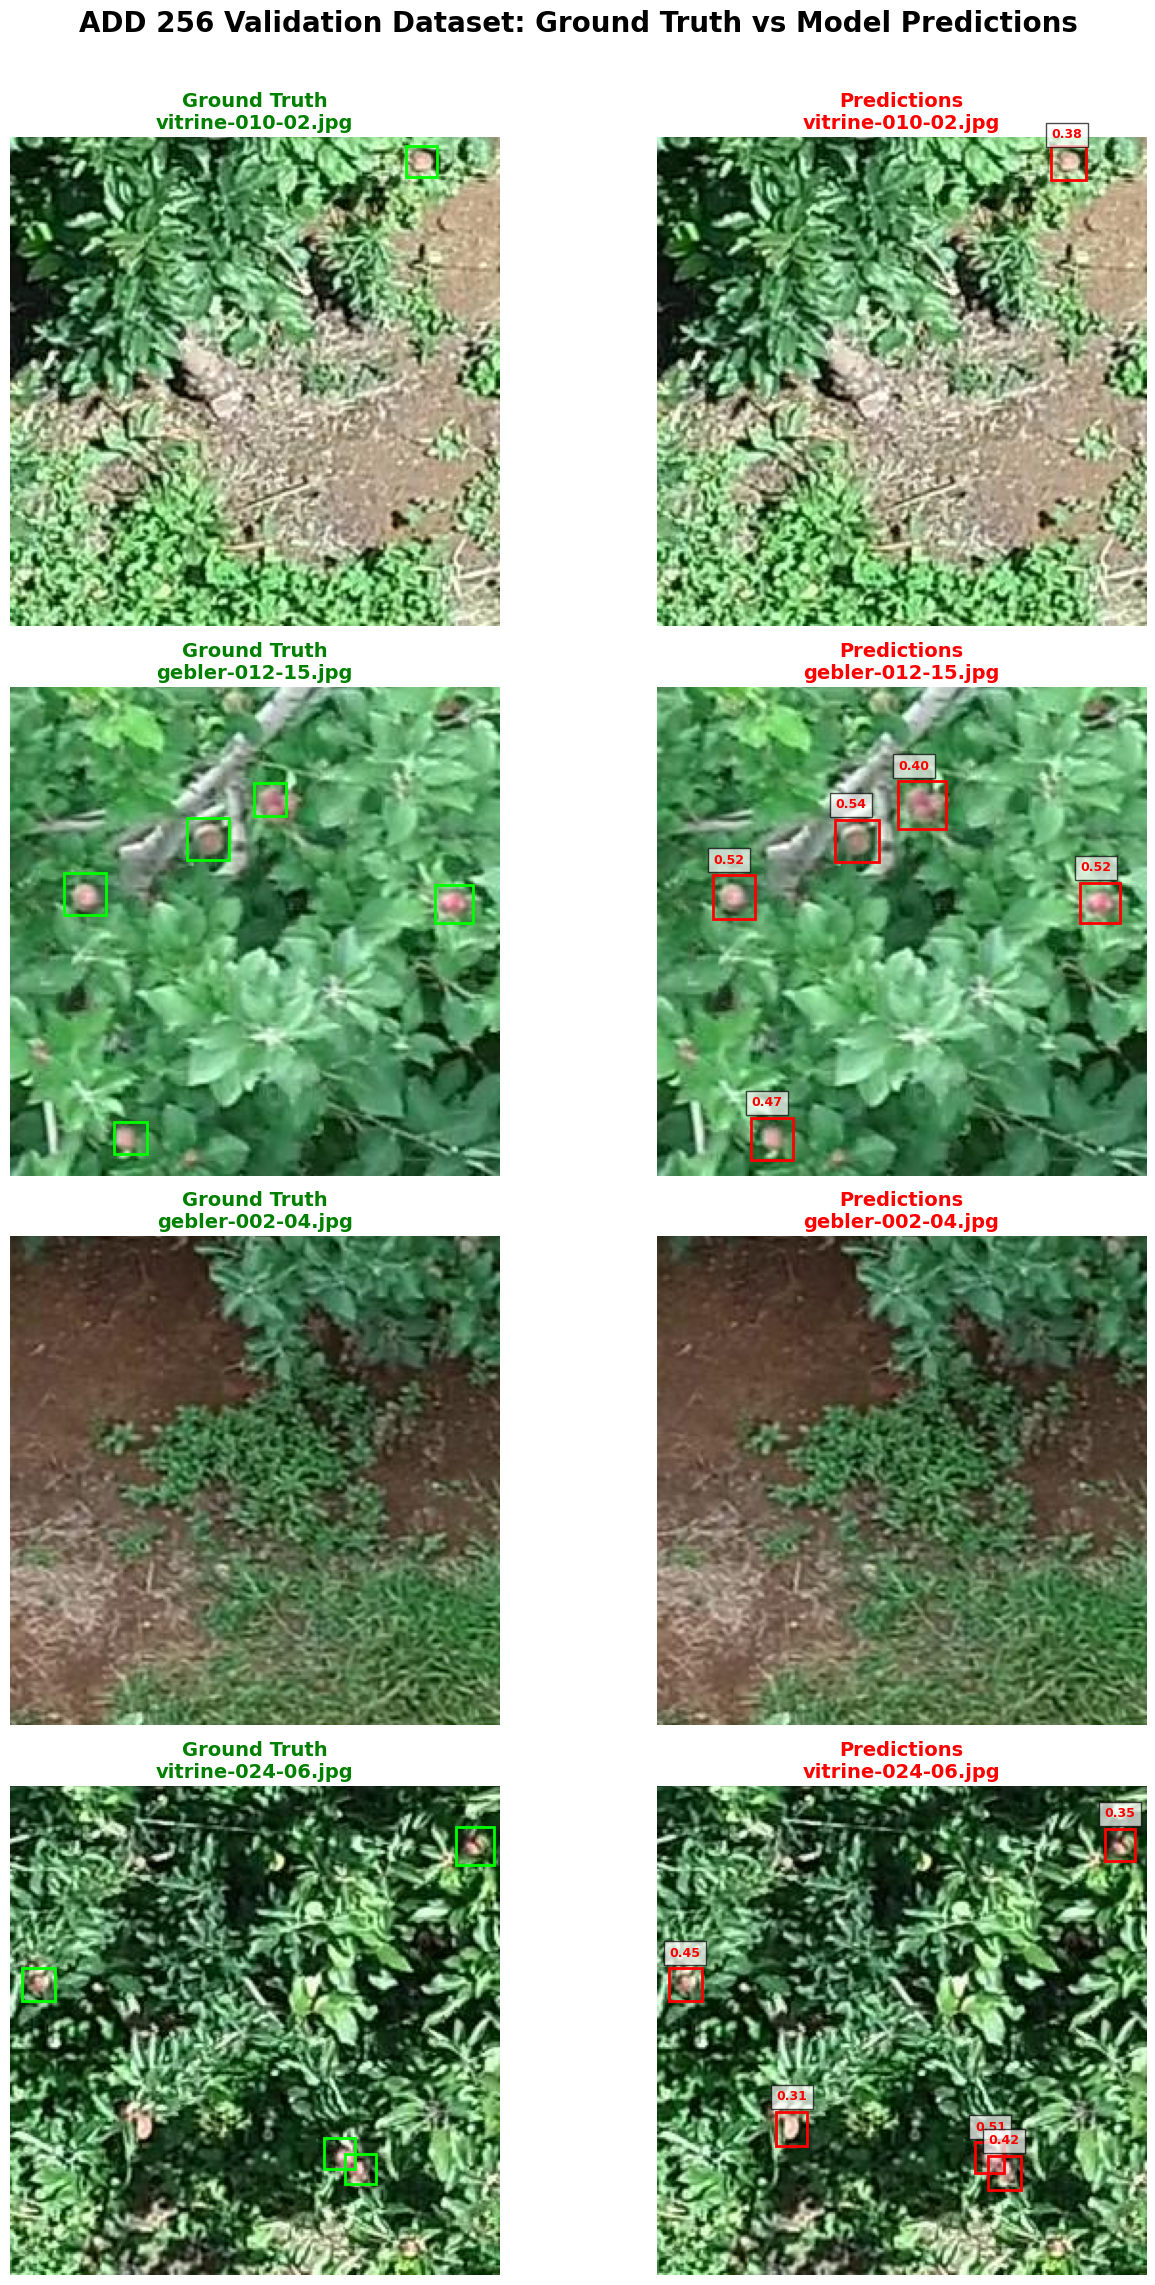


✓ Saved visualization: /content/drive/My Drive/YOLO_ADD256_Finetuning/Visualizations/YOLOv8_ADD256_val_predictions_vs_gt.png


In [17]:
# ==========================================================================
# CELL 11: VISUALIZE MODEL PREDICTIONS vs GROUND TRUTH
# ==========================================================================
"""
Visualize model predictions compared to ground truth:
- Left plot: Ground truth bounding boxes (lime green)
- Right plot: Model predicted boxes (red) with confidence scores
For 4 random validation images.
"""

import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
from matplotlib.patches import Rectangle
from ultralytics import YOLO

print("="*80)
print("VISUALIZING MODEL PREDICTIONS VS GROUND TRUTH")
print("="*80)

# Paths
dataset_processed_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/ADD256_YOLO_Format')
models_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Models')
val_images_dir = dataset_processed_dir / 'images' / 'val'
val_labels_dir = dataset_processed_dir / 'labels' / 'val'
visualizations_dir = Path('/content/drive/My Drive/YOLO_ADD256_Finetuning/Visualizations')

# Load best model
best_model_path = models_dir / 'YOLOv8_ADD256_best_finetuned.pt'
if best_model_path.exists():
    model = YOLO(str(best_model_path))
    print(f"✓ Loaded model: {best_model_path.name}")
else:
    last_model_path = models_dir / 'YOLOv8_ADD256_last_finetuned.pt'
    if last_model_path.exists():
        model = YOLO(str(last_model_path))
        print(f"✓ Loaded model: {last_model_path.name}")
    else:
        raise Exception("No fine-tuned model found!")

# Get 4 random validation images
all_val_images = sorted(list(val_images_dir.glob('*.jpg')))
random.seed(42)
sample_val_images = random.sample(all_val_images, min(4, len(all_val_images)))

print("Selected 4 random validation images:")
for im in sample_val_images:
    print(f" - {im.name}")

# Prepare plot: 2 columns (GT, prediction), 4 rows
fig, axes = plt.subplots(4, 2, figsize=(14, 24))
fig.suptitle('ADD 256 Validation Dataset: Ground Truth vs Model Predictions', fontsize=20, fontweight='bold')

for i, img_path in enumerate(sample_val_images):
    # Load image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]

    # LEFT: Ground Truth
    ax_gt = axes[i, 0]
    ax_gt.imshow(img_rgb)
    ax_gt.set_title(f"Ground Truth\n{img_path.name}", fontsize=14, color='green', fontweight='bold')
    ax_gt.axis('off')

    # Load ground truth labels
    label_file = val_labels_dir / f"{img_path.stem}.txt"
    if label_file.exists():
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    cx_norm, cy_norm, w_norm, h_norm = map(float, parts[1:5])
                    x_min = int((cx_norm - w_norm/2) * img_width)
                    y_min = int((cy_norm - h_norm/2) * img_height)
                    box_width = int(w_norm * img_width)
                    box_height = int(h_norm * img_height)
                    rect = Rectangle((x_min, y_min), box_width, box_height, linewidth=2, edgecolor='lime', facecolor='none')
                    ax_gt.add_patch(rect)

    # RIGHT: Model Predictions
    ax_pred = axes[i, 1]
    ax_pred.imshow(img_rgb)
    ax_pred.set_title(f"Predictions\n{img_path.name}", fontsize=14, color='red', fontweight='bold')
    ax_pred.axis('off')

    # Run model inference
    results = model.predict(source=str(img_path), conf=0.3, verbose=False)
    if results and len(results) > 0:
        preds = results[0].boxes
        if preds is not None:
            for pred in preds:
                x1, y1, x2, y2 = map(int, pred.xyxy[0].cpu().numpy())
                score = float(pred.conf[0].cpu().numpy())
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
                ax_pred.add_patch(rect)
                ax_pred.text(x1, max(y1 - 6, 0), f"{score:.2f}", color='red', fontsize=9, weight='bold',
                             bbox=dict(facecolor='white', alpha=0.7))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
output_path = visualizations_dir / 'YOLOv8_ADD256_val_predictions_vs_gt.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Saved visualization: {output_path}")